In [6]:
%%capture
!pip install geemap
!pip install rasterio
!pip install geedim

In [7]:
import os.path
out_dir = os.path.expanduser('~/Downloads')
import zipfile
import os # we import hte necessary packages

# Import necessary modules
import geemap
import ee
import numpy as np
import rasterio # here we want to plot the data we received
import matplotlib.pyplot as plt


In [8]:
from geopy import distance
import copy


In [9]:
ee.Authenticate() # we authenticate
# and intialize geemap
ee.Initialize(project='ee-encodersmap1')

In [10]:
from google.colab import drive # we mount the drive for later downloading of the files
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:

# Define the region of interest (roiComputed)
roiComputed = ee.Geometry.Polygon(
    [[[-12.15, 31.8],
      [36.15, 31.8],
      [36.15, 72.15],
      [-12.15, 72.15]]])



In [12]:
grid = geemap.create_grid(roiComputed, 2e5)

# Loop through the tiles of the grid
grid_dict = ((grid.getInfo())['features'][0])
copied_dict_list = copy.deepcopy(((grid.getInfo())['features']))



# Loop through the coordinates and modify them
grid_features_list = copy.deepcopy((grid.getInfo())['features'])

names_of_images = []

for  i in range(len((grid.getInfo())['features'])):

  coordinates = (grid_features_list[i])['geometry']['coordinates'][0]

  north_latitude = max(coord[1] for coord in coordinates)
  south_latitude = min(coord[1] for coord in coordinates)
  west_longitude = min(coord[0] for coord in coordinates)
  east_longitude = max(coord[0] for coord in coordinates)

  name_ofImage = 'N'+str(north_latitude).replace('.', '_')+'S'+str(south_latitude).replace('.', '_')+'W'+str(west_longitude).replace('.', '_')+'E'+str(east_longitude).replace('.', '_')
  names_of_images.append(name_ofImage)

  north_latitude += 0.3
  south_latitude -= 0.3
  west_longitude -= 0.5
  east_longitude += 0.5


  modified_coordinates = [[west_longitude,south_latitude],[east_longitude,south_latitude],[east_longitude,north_latitude],[west_longitude,north_latitude],[west_longitude,south_latitude]]
  updated_dict = {'coordinates': [modified_coordinates]}
  # Update the modified coordinates in the dictionary

  copied_dict_list[i]['geometry'].update(updated_dict)


copied_dict = ((grid.getInfo())['features'][0]).copy()
copied_dict

{'type': 'Feature',
 'geometry': {'geodesic': False,
  'crs': {'type': 'name', 'properties': {'name': 'EPSG:4326'}},
  'type': 'Polygon',
  'coordinates': [[[-12.576413977673301, 30.542719660063728],
    [-10.779783409434257, 30.542719660063728],
    [-10.779783409434257, 32.33935022830277],
    [-12.576413977673301, 32.33935022830277],
    [-12.576413977673301, 30.542719660063728]]]},
 'id': '-7,17',
 'properties': {}}

In [13]:
# Create a FeatureCollection from the list of features
feature_collection = ee.FeatureCollection(copied_dict_list)


In [14]:

# Load the MODIS/061/MOD15A2H collection
modis_collection = ee.ImageCollection("CAS/IGSNRR/PML/V2_v017")

# Filter the collection by the region of interest and year
filtered_collection = modis_collection.filterBounds(roiComputed) \
                                      .filterDate('2015-05-01', '2015-11-01')

# Print the filtered collection
print(filtered_collection)

# Select the desired bands ("Ec", "Es", "Ei") from the filtered collection
desired_band_names = ["Es"]
filtered_collection = filtered_collection.select(desired_band_names)

# Print the modified collection
print(filtered_collection)


# Function to calculate yearly average
def calculate_yearly_average(image):
    year = ee.Date(image.get('system:time_start')).get('year')
    return image.set('year', year)

# Map the function over the collection
yearly_averages = filtered_collection.map(calculate_yearly_average)

# Reduce the collection to yearly averages within the specified region of interest
yearly_averages_roi = yearly_averages.mean().clip(roiComputed)

# Display the yearly averages within the region of interest on the map
Map = geemap.Map()
Map.centerObject(roiComputed, 6)
Map.addLayer(yearly_averages_roi, {}, 'Yearly Average (2015)')

# Display the grid on the map
Map.addLayer(feature_collection, {}, 'Grid')

# Display the map
Map



/usr/local/lib/python3.10/dist-packages/ee/deprecation.py:207: DeprecationWarning: 

Attention required for CAS/IGSNRR/PML/V2_v017! You are using a deprecated asset.
To ensure continued functionality, please update it.
Learn more: https://developers.google.com/earth-engine/datasets/catalog/CAS_IGSNRR_PML_V2_v017

  warnings.warn(warning, category=DeprecationWarning)


ee.ImageCollection({
  "functionInvocationValue": {
    "functionName": "Collection.filter",
    "arguments": {
      "collection": {
        "functionInvocationValue": {
          "functionName": "Collection.filter",
          "arguments": {
            "collection": {
              "functionInvocationValue": {
                "functionName": "ImageCollection.load",
                "arguments": {
                  "id": {
                    "constantValue": "CAS/IGSNRR/PML/V2_v017"
                  }
                }
              }
            },
            "filter": {
              "functionInvocationValue": {
                "functionName": "Filter.intersects",
                "arguments": {
                  "leftField": {
                    "constantValue": ".all"
                  },
                  "rightValue": {
                    "functionInvocationValue": {
                      "functionName": "Feature",
                      "arguments": {
                        

Map(center=[50.998399862311786, 11.999999999999998], controls=(WidgetControl(options=['position', 'transparent…

In [15]:
# Define the bounding box for Malta (lon, lat)
malta_bbox = [14.14, 35.8, 14.58, 37.20]  # [min_lon, min_lat, max_lon, max_lat]

# Create a rectangle geometry using the bounding box
roi = ee.Geometry.Rectangle(malta_bbox)


In [18]:
nominal_scale = filtered_collection.first().projection().nominalScale().getInfo()
nominal_scale

463.83121163863984

In [19]:
Map = geemap.Map()
Map.addLayer(roi)
filtered_collection.first().clip(roiComputed)
Map.addLayer(filtered_collection.first(), {}, 'Es')
geemap.ee_export_image(filtered_collection.map(calculate_yearly_average).mean().clip(roi), 'image.tif', scale= nominal_scale)

Map

Generating URL ...
Please wait ...
Data downloaded to /content/image.tif


Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

In [20]:
nominal_scale = filtered_collection.first().projection().nominalScale().getInfo()
nominal_scale

463.83121163863984

In [21]:
# Get the CRS of the yearly_averages_roi
crs = yearly_averages_roi.projection().getInfo()['crs']

# Print the CRS
print("CRS:", crs)


CRS: EPSG:4326


In [22]:
output_path = "SoilEvaporation2015"


In [23]:
geemap.download_ee_image_tiles(yearly_averages_roi,feature_collection, output_path,scale=nominal_scale ,crs=crs)

001.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

There is no STAC entry for: None


002.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

003.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

004.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

005.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

006.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

007.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

008.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

009.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

010.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

011.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

012.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

013.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

014.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

015.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

016.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

017.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

018.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

019.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

020.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

021.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

022.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

023.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

024.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

025.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

026.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

027.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

028.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

029.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

030.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

031.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

032.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

033.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

034.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

035.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

036.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

037.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

038.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

039.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

040.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

041.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

042.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

043.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

044.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

045.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

046.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

047.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

048.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

049.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

050.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

051.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

052.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

053.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

054.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

055.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

056.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

057.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

058.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

059.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

060.tif: |          | 0.00/3.11M (raw) [  0.0%] in 00:00 (eta:     ?)

061.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

062.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

063.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

064.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

065.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

066.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

067.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

068.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

069.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

070.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

071.tif: |          | 0.00/3.11M (raw) [  0.0%] in 00:00 (eta:     ?)

072.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

073.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

074.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

075.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

076.tif: |          | 0.00/3.11M (raw) [  0.0%] in 00:00 (eta:     ?)

077.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

078.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

079.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

080.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

081.tif: |          | 0.00/3.11M (raw) [  0.0%] in 00:00 (eta:     ?)

082.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

083.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

084.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

085.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

086.tif: |          | 0.00/3.11M (raw) [  0.0%] in 00:00 (eta:     ?)

087.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

088.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

089.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

090.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

091.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

092.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

093.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

094.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

095.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

096.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

097.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

098.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

099.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

100.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

101.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

102.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

103.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

104.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

105.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

106.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

107.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

108.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

109.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

110.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

111.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

112.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

113.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

114.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

115.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

116.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

117.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

118.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

119.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

120.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

121.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

122.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

123.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

124.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

125.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

126.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

127.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

128.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

129.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

130.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

131.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

132.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

133.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

134.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

135.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

136.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

137.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

138.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

139.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

140.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

141.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

142.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

143.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

144.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

145.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

146.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

147.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

148.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

149.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

150.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

151.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

152.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

153.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

154.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

155.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

156.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

157.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

158.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

159.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

160.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

161.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

162.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

163.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

164.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

165.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

166.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

167.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

168.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

169.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

170.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

171.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

172.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

173.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

174.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

175.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

176.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

177.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

178.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

179.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

180.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

181.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

182.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

183.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

184.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

185.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

186.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

187.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

188.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

189.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

190.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

191.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

192.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

193.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

194.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

195.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

196.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

197.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

198.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

199.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

200.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

201.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

202.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

203.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

204.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

205.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

206.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

207.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

208.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

209.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

210.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

211.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

212.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

213.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

214.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

215.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

216.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

217.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

218.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

219.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

220.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

221.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

222.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

223.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

224.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

225.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

226.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

227.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

228.tif: |          | 0.00/3.11M (raw) [  0.0%] in 00:00 (eta:     ?)

229.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

230.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

231.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

232.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

233.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

234.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

235.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

236.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

237.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

238.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

239.tif: |          | 0.00/3.11M (raw) [  0.0%] in 00:00 (eta:     ?)

240.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

241.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

242.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

243.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

244.tif: |          | 0.00/3.11M (raw) [  0.0%] in 00:00 (eta:     ?)

245.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

246.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

247.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

248.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

249.tif: |          | 0.00/3.11M (raw) [  0.0%] in 00:00 (eta:     ?)

250.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

251.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

252.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

253.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

254.tif: |          | 0.00/3.11M (raw) [  0.0%] in 00:00 (eta:     ?)

255.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

256.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

257.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

258.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

259.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

260.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

261.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

262.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

263.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

264.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

265.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

266.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

267.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

268.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

269.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

270.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

271.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

272.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

273.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

274.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

275.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

276.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

277.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

278.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

279.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

280.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

281.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

282.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

283.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

284.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

285.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

286.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

287.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

288.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

289.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

290.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

291.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

292.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

293.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

294.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

295.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

296.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

297.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

298.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

299.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

300.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

301.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

302.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

303.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

304.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

305.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

306.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

307.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

308.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

309.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

310.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

311.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

312.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

313.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

314.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

315.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

316.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

317.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

318.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

319.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

320.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

321.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

322.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

323.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

324.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

325.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

326.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

327.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

328.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

329.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

330.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

331.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

332.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

333.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

334.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

335.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

336.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

337.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

338.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

339.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

340.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

341.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

342.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

343.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

344.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

345.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

346.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

347.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

348.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

349.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

350.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

351.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

352.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

353.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

354.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

355.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

356.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

357.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

358.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

359.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

360.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

361.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

362.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

363.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

364.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

365.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

366.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

367.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

368.tif: |          | 0.00/3.11M (raw) [  0.0%] in 00:00 (eta:     ?)

369.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

370.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

371.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

372.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

373.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

374.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

375.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

376.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

377.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

378.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

379.tif: |          | 0.00/3.11M (raw) [  0.0%] in 00:00 (eta:     ?)

380.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

381.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

382.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

383.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

384.tif: |          | 0.00/3.11M (raw) [  0.0%] in 00:00 (eta:     ?)

385.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

386.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

387.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

388.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

389.tif: |          | 0.00/3.11M (raw) [  0.0%] in 00:00 (eta:     ?)

390.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

391.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

392.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

393.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

394.tif: |          | 0.00/3.11M (raw) [  0.0%] in 00:00 (eta:     ?)

395.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

396.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

397.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

398.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

399.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

400.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

401.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

402.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

403.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

404.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

405.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

406.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

407.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

408.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

409.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

410.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

411.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

412.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

413.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

414.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

415.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

416.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

417.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

418.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

419.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

420.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

421.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

422.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

423.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

424.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

425.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

426.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

427.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

428.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

429.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

430.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

431.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

432.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

433.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

434.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

435.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

436.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

437.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

438.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

439.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

440.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

441.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

442.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

443.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

444.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

445.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

446.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

447.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

448.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

449.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

450.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

451.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

452.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

453.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

454.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

455.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

456.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

457.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

458.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

459.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

460.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

461.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

462.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

463.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

464.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

465.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

466.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

467.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

468.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

469.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

470.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

471.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

472.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

473.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

474.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

475.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

476.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

477.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

478.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

479.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

480.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

481.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

482.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

483.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

484.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

485.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

486.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

487.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

488.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

489.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

490.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

491.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

492.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

493.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

494.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

495.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

496.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

497.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

498.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

499.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

500.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

501.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

502.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

503.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

504.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

505.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

506.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

507.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

508.tif: |          | 0.00/3.11M (raw) [  0.0%] in 00:00 (eta:     ?)

509.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

510.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

511.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

512.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

513.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

514.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

515.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

516.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

517.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

518.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

519.tif: |          | 0.00/3.11M (raw) [  0.0%] in 00:00 (eta:     ?)

520.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

521.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

522.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

523.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

524.tif: |          | 0.00/3.11M (raw) [  0.0%] in 00:00 (eta:     ?)

525.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

526.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

527.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

528.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

529.tif: |          | 0.00/3.11M (raw) [  0.0%] in 00:00 (eta:     ?)

530.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

531.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

532.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

533.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

534.tif: |          | 0.00/3.11M (raw) [  0.0%] in 00:00 (eta:     ?)

535.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

536.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

537.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

538.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

539.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

540.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

541.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

542.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

543.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

544.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

545.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

546.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

547.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

548.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

549.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

550.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

551.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

552.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

553.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

554.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

555.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

556.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

557.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

558.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

559.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

560.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

561.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

562.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

563.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

564.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

565.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

566.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

567.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

568.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

569.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

570.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

571.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

572.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

573.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

574.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

575.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

576.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

577.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

578.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

579.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

580.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

581.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

582.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

583.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

584.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

585.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

586.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

587.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

588.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

589.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

590.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

591.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

592.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

593.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

594.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

595.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

596.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

597.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

598.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

599.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

600.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

601.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

602.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

603.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

604.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

605.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

606.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

607.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

608.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

609.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

610.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

611.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

612.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

613.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

614.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

615.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

616.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

617.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

618.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

619.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

620.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

621.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

622.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

623.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

624.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

625.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

626.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

627.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

628.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

629.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

630.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

631.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

632.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

633.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

634.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

635.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

636.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

637.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

638.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

639.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

640.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

641.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

642.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

643.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

644.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

645.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

646.tif: |          | 0.00/3.10M (raw) [  0.0%] in 00:00 (eta:     ?)

Downloaded 646 tiles in 2552.5880222320557 seconds.


In [24]:

with rasterio.open('/content/image.tif') as src:
                raster_data2 = src.read()
                print(np.mean(raster_data2[raster_data2 !=0]))
                raster_data = raster_data2.copy()
                # Set NaN values to the desired value for all bands
                for band in range(src.count):
                    non_nan_values = raster_data[band][raster_data != 0.0]
                    # we replace for each band to the value  computed by removing
                    # the nan values, we then set the nans to that values
                    average_values = np.mean(non_nan_values)
                    print(average_values)
                    if np.isnan(average_values):
                      raster_data[band][np.isnan(raster_data[band])] = 0.94523195
                    else:
                      raster_data[band][np.isnan(raster_data[band])] = average_values

                # Update the metadata to reflect the modified raster
                profile = src.profile

                # Write the modified raster to the output folder
                with rasterio.open('/content/image2.tif', 'w', **profile) as dst:
                    dst.write(raster_data)


1.0800242140468228


IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

Band 1: None
BoundingBox(left=14.1375, bottom=35.795833333333334, right=14.583333333333332, top=37.204166666666666)


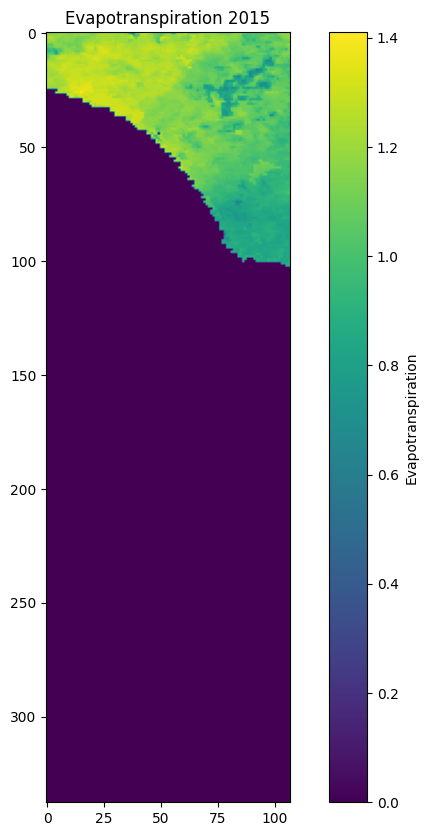

[[1.17434783 1.12782609 1.10391304 ... 1.17173913 1.13217391 1.17217391]
 [1.19130435 1.19086957 1.20217391 ... 1.14521739 1.17       1.17434783]
 [1.22608696 1.24826087 1.24782609 ... 1.1573913  1.1573913  1.20478261]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


In [25]:
import rasterio
import matplotlib.pyplot as plt

# Read the raster file
file_path ='/content/image.tif'
dataset = rasterio.open(file_path)
# Get the band names
band_names = dataset.descriptions

# Print the band names
for band_index, band_name in enumerate(band_names, start=1):
    print(f"Band {band_index}: {band_name}")
# Read the raster data
raster_data = dataset.read(1)
print(dataset.bounds)

# Visualize the raster data
plt.figure(figsize=(10, 10))
plt.imshow(raster_data, cmap='viridis')
plt.colorbar(label='Evapotranspiration')
plt.title('Evapotranspiration 2015')
plt.show()
print(raster_data)


In [26]:
# Specify the directory where the .tif files are located

directory_path = "/content/SoilEvaporation2015v3"

In [27]:
import os
import rasterio
import numpy as np

def set_nan_to_value(input_folder, output_folder):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for filename in os.listdir(input_folder):
        if filename.endswith(".tif"):
            input_path = os.path.join(input_folder, filename)
            output_path = os.path.join(output_folder, filename)

            with rasterio.open(input_path) as src:
                raster_data = src.read()

                # Set NaN values to the desired value for all bands
                for band in range(src.count):
                    non_nan_values = raster_data[band][~np.isnan(raster_data[band])]
                    # we replace for each band to the value  computed by removing
                    # the nan values, we then set the nans to that values
                    average_values = np.mean(non_nan_values)
                    if np.isnan(average_values):
                      raster_data[band][np.isnan(raster_data[band])] = 0.94523195
                    else:
                      raster_data[band][np.isnan(raster_data[band])] = average_values

                # Update the metadata to reflect the modified raster
                profile = src.profile

                # Write the modified raster to the output folder
                with rasterio.open(output_path, 'w', **profile) as dst:
                    dst.write(raster_data)


# Specify the input folder containing the TIFF files
input_folder_path = "/content/SoilEvaporation2015"

# Specify the output folder where the modified TIFF files will be saved
output_folder_path = "/content/SoilEvaporation2015v4"


# Call the function to process the TIFF files
set_nan_to_value(input_folder_path, output_folder_path)


In [28]:
def delete_same_value_tif(directory):
    for filename in os.listdir(directory):
        if filename.endswith(".tif"):
            tif_path = os.path.join(directory, filename)
            with rasterio.open(tif_path) as dataset:
                raster_data = dataset.read(1)

                # Check if all data points have the same value
                if (raster_data == raster_data[0]).all():
                    os.remove(tif_path)
                    print(f"Deleted {filename}")
delete_same_value_tif(output_folder_path)

Deleted 046.tif
Deleted 639.tif
Deleted 600.tif
Deleted 024.tif
Deleted 606.tif
Deleted 574.tif
Deleted 518.tif
Deleted 625.tif
Deleted 479.tif
Deleted 376.tif
Deleted 395.tif
Deleted 640.tif
Deleted 451.tif
Deleted 456.tif
Deleted 374.tif
Deleted 635.tif
Deleted 626.tif
Deleted 403.tif
Deleted 537.tif
Deleted 257.tif
Deleted 631.tif
Deleted 511.tif
Deleted 425.tif
Deleted 059.tif
Deleted 028.tif
Deleted 592.tif
Deleted 591.tif
Deleted 564.tif
Deleted 367.tif
Deleted 125.tif
Deleted 339.tif
Deleted 620.tif
Deleted 602.tif
Deleted 619.tif
Deleted 535.tif
Deleted 426.tif
Deleted 459.tif
Deleted 483.tif
Deleted 045.tif
Deleted 542.tif
Deleted 507.tif
Deleted 627.tif
Deleted 515.tif
Deleted 645.tif
Deleted 572.tif
Deleted 431.tif
Deleted 347.tif
Deleted 546.tif
Deleted 636.tif
Deleted 641.tif
Deleted 255.tif
Deleted 402.tif
Deleted 199.tif
Deleted 569.tif
Deleted 540.tif
Deleted 601.tif
Deleted 396.tif
Deleted 087.tif
Deleted 646.tif
Deleted 547.tif
Deleted 634.tif
Deleted 565.tif
Deleted 

In [29]:

def rename_tif_files(directory):
    count = 0
    for file_name in os.listdir(directory):
        if file_name.endswith('.tif'):
            file_path = os.path.join(directory, file_name)
            combined_string = get_combined_string(file_path) # getting new name
            new_file_name = 'ID'+str(count)+combined_string + '.tif' # renaming the file
            new_file_path = os.path.join(directory, new_file_name)
            os.rename(file_path, new_file_path)
            count += 1 # counting the ID of the gile

def get_combined_string(tif_file):
    with rasterio.open(tif_file) as src:

        bounds = src.bounds
        bounds_right = bounds.right
        bounds_left = bounds.left
        bounds_top = bounds.top
        bounds_bottom = bounds.bottom

              # Ensure bounds.top > bounds.bottom
        if bounds_top <  bounds_bottom:
            bounds_top,  bounds_bottom =  bounds_bottom, bounds_top

        # Ensure bounds.right > bounds.left
        if  bounds_right <  bounds_left:
             bounds_right,  bounds_left =  bounds_left, bounds_right

        bounds_top -= 0.3
        bounds_bottom += 0.3
        bounds_right -= 0.5
        bounds_left += 0.5


        right_string = str(float( bounds_right)).replace('.', '_')
        left_string = str(float(bounds_left)).replace('.', '_')
        top_string = str(float(bounds_top)).replace('.', '_')
        bottom_string = str(float( bounds_bottom)).replace('.', '_')
        combined_string = f"N{top_string}S{bottom_string}W{left_string}E{right_string}"
        return combined_string

# Example usage
rename_tif_files('/content/SoilEvaporation2015v4')


In [30]:
directory_path = '/content/SoilEvaporation2015v4'

In [31]:

import re

def extract_number_from_filename(filename):
    pattern = r"^ID(\d+)N"
    match = re.match(pattern, filename)
    if match:
        number = int(match.group(1))
        return number
    else:
        return None

def get_average_bounds(tif_path):
    with rasterio.open(tif_path) as dataset:
        bounds = dataset.bounds
        average_top_bottom = (bounds.top + bounds.bottom) / 2.0
        average_left_right = (bounds.left + bounds.right) / 2.0

    return average_top_bottom, average_left_right

# Specify the directory where the .tif files are located

tif_files = [filename for filename in os.listdir(directory_path) if filename.endswith(".tif")]

bounds_array = np.empty((len(tif_files), 3), dtype=np.float32)

for i, tif_file in enumerate(tif_files):
    tif_path = os.path.join(directory_path, tif_file)
    average_top_bottom, average_left_right = get_average_bounds(tif_path)
    bounds_array[i, 0] = extract_number_from_filename(tif_file)
    bounds_array[i, 1] = average_top_bottom
    bounds_array[i, 2] = average_left_right

print("Bounds Array:")
print(bounds_array)

# Create the output directory if it doesn't exist
output_directory = "/content/SoilEvaporationv4"
os.makedirs(output_directory, exist_ok=True)

# Save the bounds_array to an .npy file
output_file = os.path.join(output_directory, "bounds_array.npy")
np.save(output_file, bounds_array)

print("Bounds array saved as:", output_file)

Bounds Array:
[[169.         45.8125     20.6625   ]
 [113.         36.83125    -2.6958334]
 [ 71.         56.59375    36.83125  ]
 ...
 [ 18.         61.983334   20.6625   ]
 [215.         54.795834   15.270833 ]
 [452.         45.8125      0.9      ]]
Bounds array saved as: /content/SoilEvaporationv4/bounds_array.npy


In [32]:
import numpy as np
from scipy.spatial import KDTree

# Extract the second and third columns for KDTree construction
points = bounds_array[:, 1:]

# Create a KDTree
kdtree = KDTree(points)

# Query the KDTree
query_point = [35.55, 14.24]
k_nearest = 5
distances, indices = kdtree.query(query_point, k=k_nearest)

print("Nearest point's distance:", distance)
print("Nearest point's index:", indices)
print("Nearest point's coordinates:", points[indices[0]])
bounds_array[54]

Nearest point's distance: <module 'geopy.distance' from '/usr/local/lib/python3.10/dist-packages/geopy/distance.py'>
Nearest point's index: [406  61 121 130 169]
Nearest point's coordinates: [36.83125 13.475  ]


array([460.     ,  56.59375,  -0.9    ], dtype=float32)

In [33]:
import shutil

# Specify the source and destination paths
source_folder = "/content/SoilEvaporation2015v4"
destination_folder = "/content/SoilEvaporationv4/SoilEvaporation"

# Move the folder to the new location
shutil.move(source_folder, destination_folder)


'/content/SoilEvaporationv4/SoilEvaporation'

In [34]:
def zip_and_download_folder(folder_path, output_filename):
    shutil.make_archive(output_filename, 'zip', folder_path)
    shutil.move(f"{output_filename}.zip", "/content/" + f"{output_filename}.zip")

# Specify the folder to be zipped and downloaded
folder_path = "/content/SoilEvaporationv4"
output_filename = "SoilEvaporation_2015_Redux"

zip_and_download_folder(folder_path, output_filename)


In [35]:
source_file_path = '/content/SoilEvaporation_2015_Redux.zip'

destination_drive_directory = '/content/drive/MyDrive/Colab Notebooks/VaesSOC/Data_Files_Redux/TifFilesRaster/'

shutil.move(source_file_path, destination_drive_directory)

'/content/drive/MyDrive/Colab Notebooks/VaesSOC/Data_Files_Redux/SoilEvaporation_2015_Redux.zip'